In [1]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import xgboost as xgb
import numpy as np

/home/agavrilenko/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/agavrilenko/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/agavrilenko/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/agavrilenko/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/agavrilenko/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/agavrilenko/an

In [2]:
import os
path = os.path.dirname(xgb.__file__)
print(path)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/xgboost


In [3]:
#help(xgboost.training.train)
help(xgb.train)

Help on function train in module xgboost.training:

train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)
    Train a booster with given parameters.
    
    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round: int
        Number of boosting iterations.
    evals: list of pairs (DMatrix, string)
        List of items to be evaluated during training, this allows user to watch
        performance on the validation set.
    obj : function
        Customized objective function.
    feval : function
        Customized evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Validation error needs to decrease at least
        every **early_stopping_rounds** round(s) to cont

In [4]:
# load data
dataset = loadtxt('data/data.txt', delimiter=",")
# split data into X and y
X = dataset[:,0:8]
Y = dataset[:,8]
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=6)

In [25]:
dtrain = xgb.DMatrix(data = X_train, label = y_train, silent= True)

deval = xgb.DMatrix(data = X_test, label = y_test, silent= True)
# evals_list = []
# evals_list.append((deval, "eval matrix"))
num_epochs = 200
params = {}
params['num_boost_round'] = num_epochs
params['early_stopping_rounds'] = 1000
#params['verbose_eval'] = 1
params['eval_metric'] = 'logloss'
params['evals_result'] = {}
params['max_depth'] = 3
params['subsample'] = 0.7




In [39]:
learning_rates = []
tresholds = []
learning_rates.append(0.1)
counter = 0
best = []
progress = dict()

def reduceLRonPlateau(i,n):

    factor = 0.1
    min_lr = 1e-20
    min_delta = 1e-10
    patience = 5
    verbose = 0
    cooldown = 3
    cooldown_counter = 0  # Cooldown counter.
    wait = 0
    #best = 0
    mode = 'min'  
    monitor_op = None
    old_lr = learning_rates[0]
    new_lr = learning_rates[0] 
    
    def in_cooldown():
            return cooldown_counter > 0
    
    def _reset(mode):
        """Resets wait counter and cooldown counter."""
        if mode not in ['auto', 'min', 'max']:
            warnings.warn('Learning Rate Plateau Reducing mode %s is unknown, '
                          'fallback to auto mode.' % (mode),
                          RuntimeWarning)
            mode = 'auto'
        if (mode == 'min' or
           (mode == 'auto' and 'acc' not in monitor)):
            monitor_op = lambda a, b: np.less(a, b - min_delta)
            best = np.Inf
        else:
            monitor_op = lambda a, b: np.greater(a, b + min_delta)
            best = -np.Inf
            
        cooldown_counter = 0
        wait = 0
        return wait, cooldown_counter
    
    def checker(wait,best, new_lr, learning_rates):
        if (i == 0):
            wait, counter = _reset(mode)
            print("initialization...")
            print("lr: ", learning_rates[0])
            best.append(100)
            
        if (i>0):
            old_lr = learning_rates[i-1]
            #new_lr = learning_rates[i-1]
            current = progress['eval']['logloss'][i-1]
            if in_cooldown():
                cooldown_counter -= 1
                wait = 0
              
            print("iter: ", i, " Current_loss: ", current, "best: ", best[i-1])
            if np.less(current, best[i-1] - min_delta):
                best.append(current)
                wait = 0
             
            elif not in_cooldown():
                #rint("not in_cooldown")
                best.append(best[-1])
                wait += 1
                if wait >= patience:
                    
                    if old_lr > min_lr:
                        new_lr = old_lr * factor
                        new_lr = max(new_lr, min_lr)
                        print("iter: ", i, "reducing lr -- ", " old_lr: ", old_lr, " new_lr: ", new_lr)
                        
#                         if self.verbose > 0:
#                             print('\nEpoch %05d: ReduceLROnPlateau reducing '
#                                   'learning rate to %s.' % (epoch + 1, new_lr))
                        cooldown_counter = cooldown
                        wait = 0
        return new_lr


       # print("step ",progress['train']['logloss'][i-1], "i = ", i)

            
    
    new_lr = checker(wait,best,new_lr,learning_rates)
    learning_rates.append(new_lr)
        
    return new_lr

In [40]:

def run_gbm(dtrain, dvalid, param, evals_result, learning_rate):
    # check training arguments in param
    n_round = param.get('num_boost_round', 100)
    early_stop = param.get('early_stopping_rounds', 0)
    verbose_eval = param.get('verbose_eval', 50)
    # specify validations set to watch performance
    watchlist = [(dtrain,'train') ,(deval,'eval')]
    #callbacks_list = [learning_rates]

    bst = xgb.train(params=param,
            dtrain=dtrain,
            num_boost_round=n_round,
            evals=watchlist,
            early_stopping_rounds=early_stop,
            verbose_eval = verbose_eval,
            evals_result = evals_result, 
            callbacks = [xgb.callback.reset_learning_rate(reduceLRonPlateau)])
                   
    return bst 

In [41]:
model1 = run_gbm(dtrain, deval, params,progress, learning_rate = 0.1)

initialization...
lr:  0.1
[0]	train-logloss:0.657127	eval-logloss:0.661149
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 1000 rounds.
iter:  1  Current_loss:  0.661149 best:  100
iter:  2  Current_loss:  0.629871 best:  0.661149
iter:  3  Current_loss:  0.608761 best:  0.629871
iter:  4  Current_loss:  0.592149 best:  0.608761
iter:  5  Current_loss:  0.571002 best:  0.592149
iter:  6  Current_loss:  0.559 best:  0.571002
iter:  7  Current_loss:  0.542816 best:  0.559
iter:  8  Current_loss:  0.532047 best:  0.542816
iter:  9  Current_loss:  0.522323 best:  0.532047
iter:  10  Current_loss:  0.515367 best:  0.522323
iter:  11  Current_loss:  0.50924 best:  0.515367
iter:  12  Current_loss:  0.505985 best:  0.50924
iter:  13  Current_loss:  0.504503 best:  0.505985
iter:  14  Current_loss:  0.498938 best:  0.504503
iter:  15  Current_loss:  0.493595 best:  0.498938
iter:  16  Current_loss:  0.49

iter:  157  Current_loss:  1.04863 best:  0.479517
iter:  158  Current_loss:  1.050341 best:  0.479517
iter:  159  Current_loss:  1.053333 best:  0.479517
iter:  160  Current_loss:  1.052488 best:  0.479517
iter:  161  Current_loss:  1.053544 best:  0.479517
iter:  162  Current_loss:  1.057473 best:  0.479517
iter:  163  Current_loss:  1.055859 best:  0.479517
iter:  164  Current_loss:  1.054303 best:  0.479517
iter:  165  Current_loss:  1.052607 best:  0.479517
iter:  166  Current_loss:  1.052692 best:  0.479517
iter:  167  Current_loss:  1.054157 best:  0.479517
iter:  168  Current_loss:  1.05077 best:  0.479517
iter:  169  Current_loss:  1.050953 best:  0.479517
iter:  170  Current_loss:  1.054398 best:  0.479517
iter:  171  Current_loss:  1.051255 best:  0.479517
iter:  172  Current_loss:  1.053906 best:  0.479517
iter:  173  Current_loss:  1.055387 best:  0.479517
iter:  174  Current_loss:  1.054261 best:  0.479517
iter:  175  Current_loss:  1.052885 best:  0.479517
iter:  176  Cu

In [42]:
# fit model no training data

model = XGBClassifier(n_estimators=num_epochs, learning_rate=0.1, subsample=0.7)

eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False,)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.7)

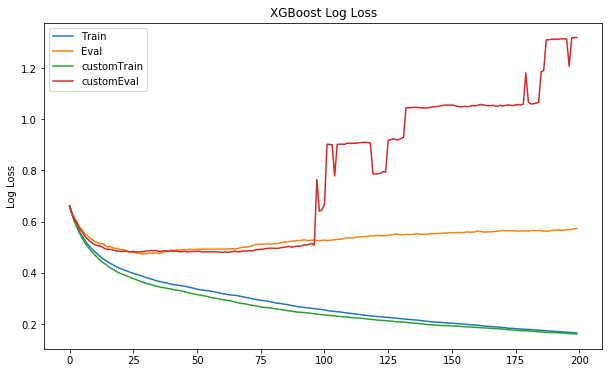

min customEval: 0.479517
min Eval: 0.473608


In [43]:
# retrieve performance metrics
results = model.evals_result()
#results1 = model1.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(10, 6))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Eval')
ax.plot(x_axis, progress['train']['logloss'], label = 'customTrain')
ax.plot(x_axis, progress['eval']['logloss'], label = 'customEval')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')

pyplot.show()
print("min customEval:", min(progress['eval']['logloss']))
print("min Eval:", min(results['validation_1']['logloss']))

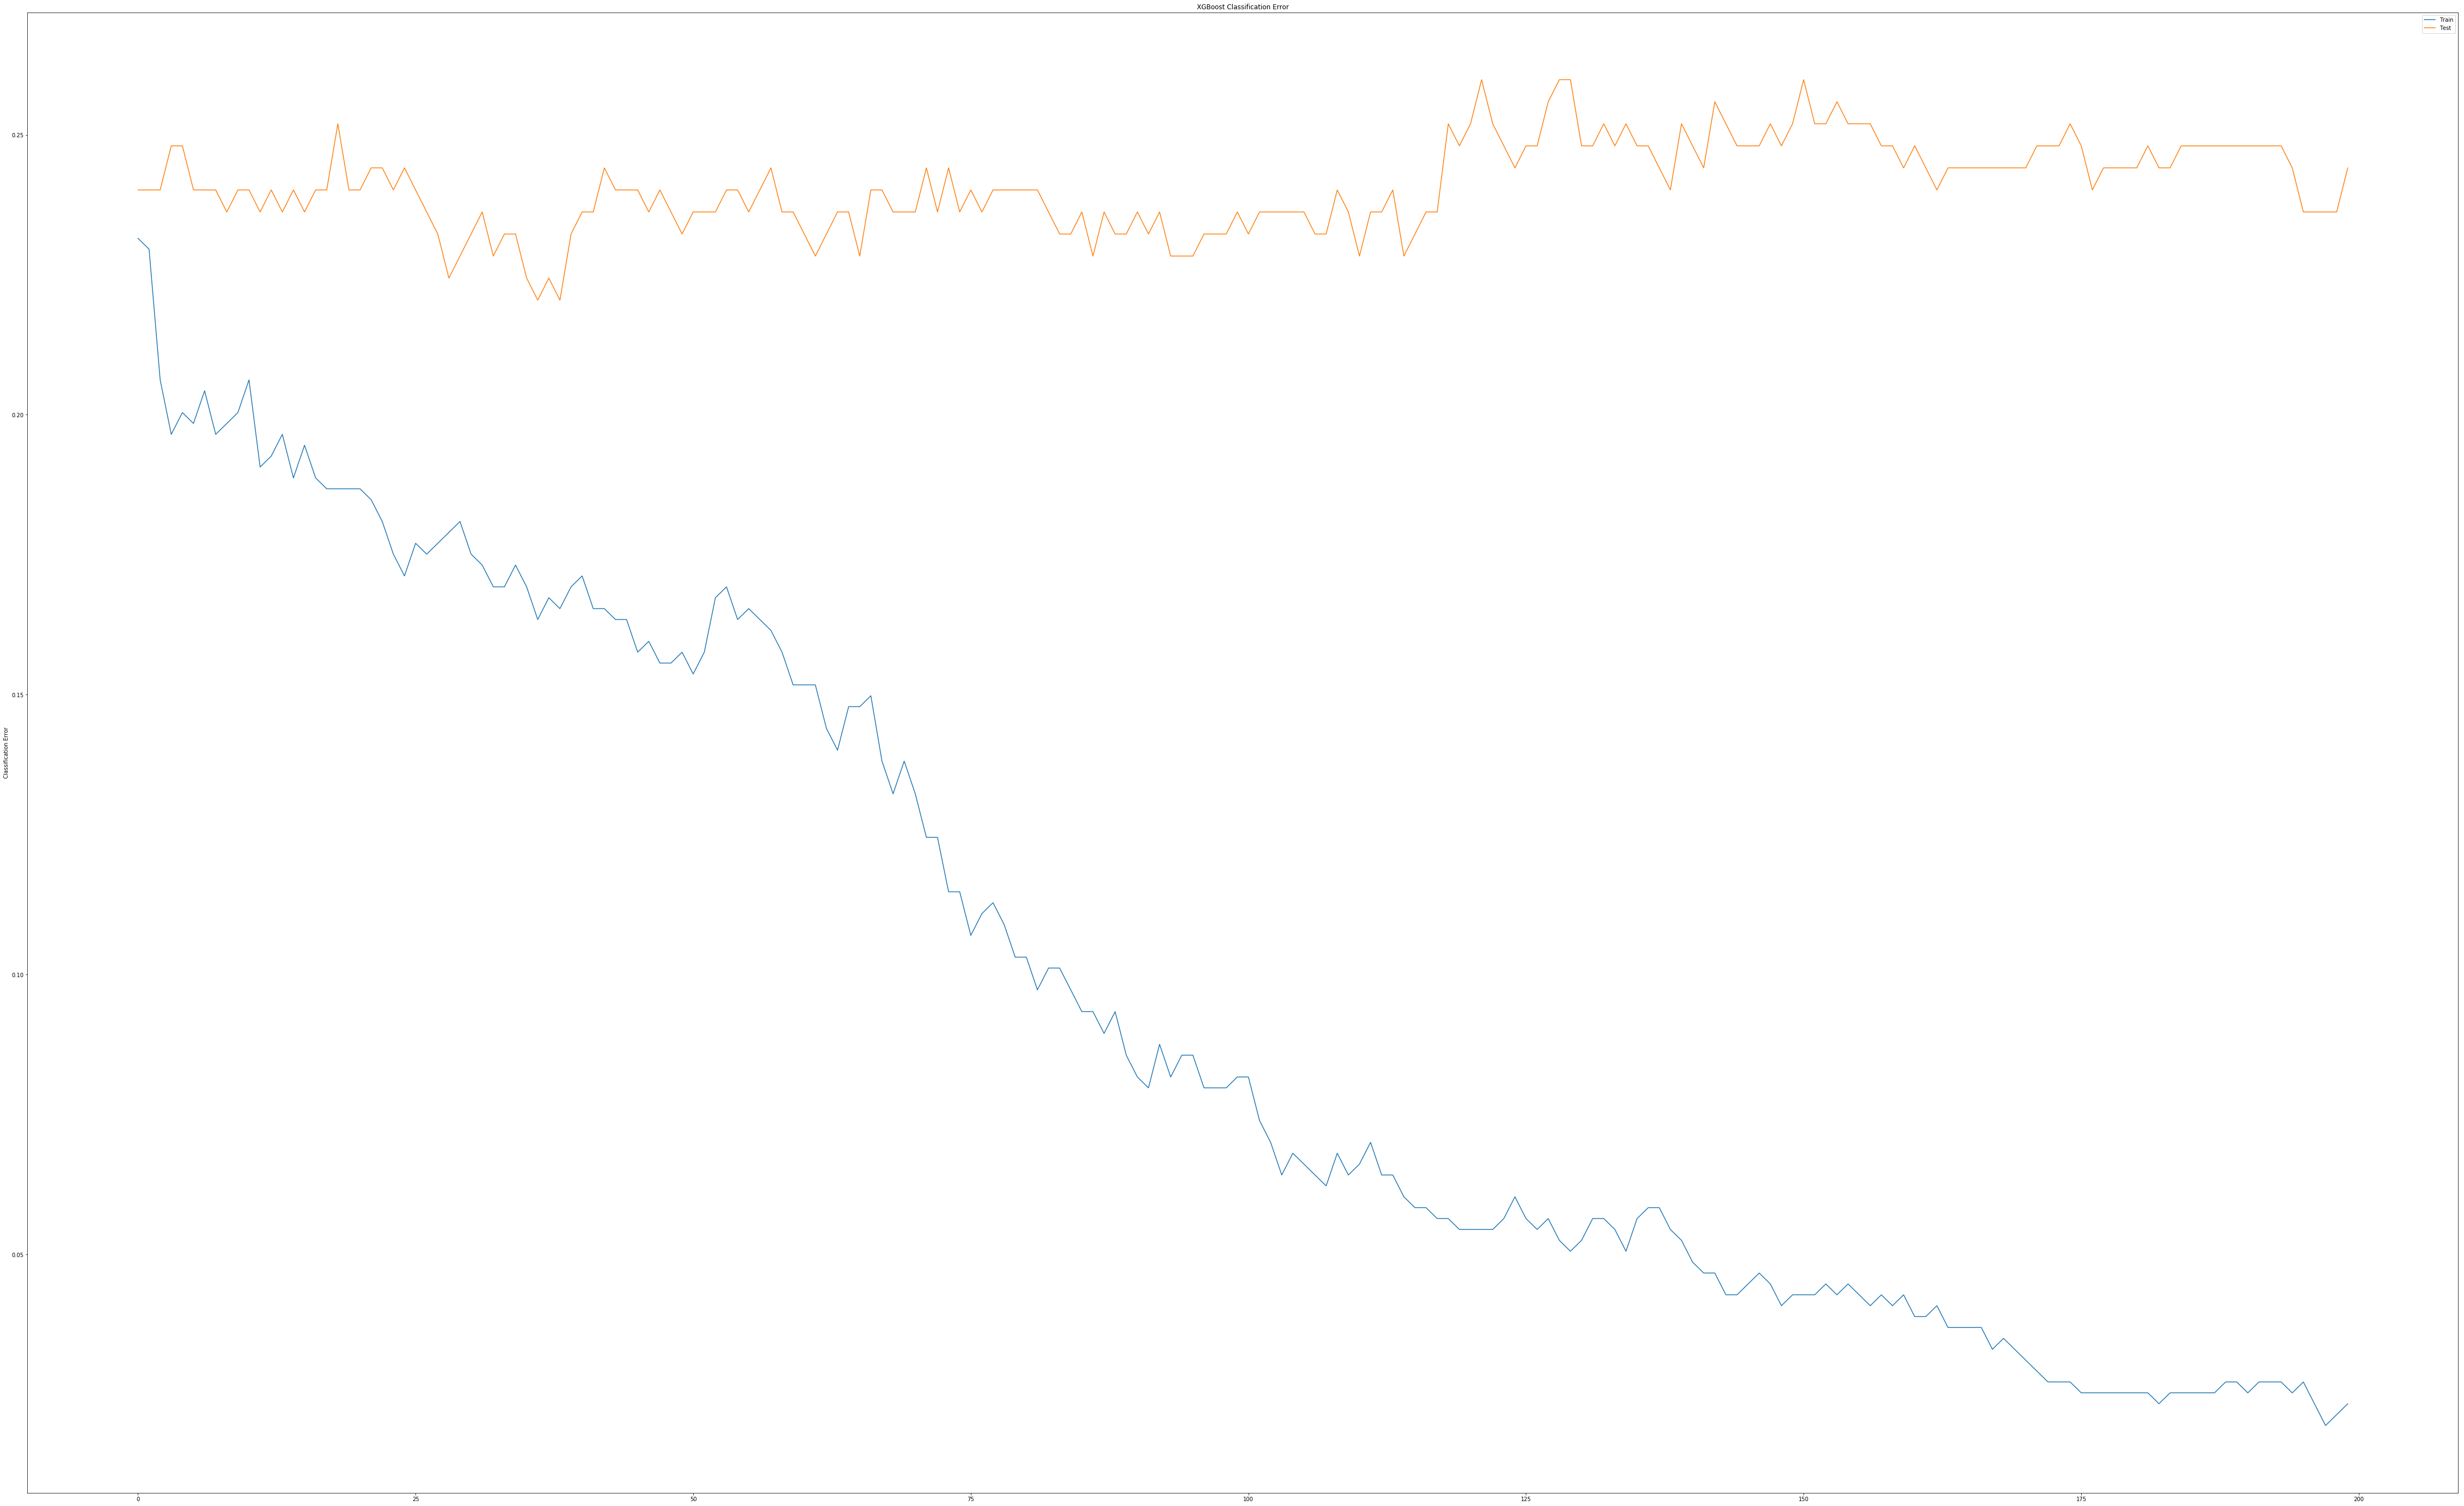

In [44]:
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('XGBoost Classification Error')
pyplot.show()

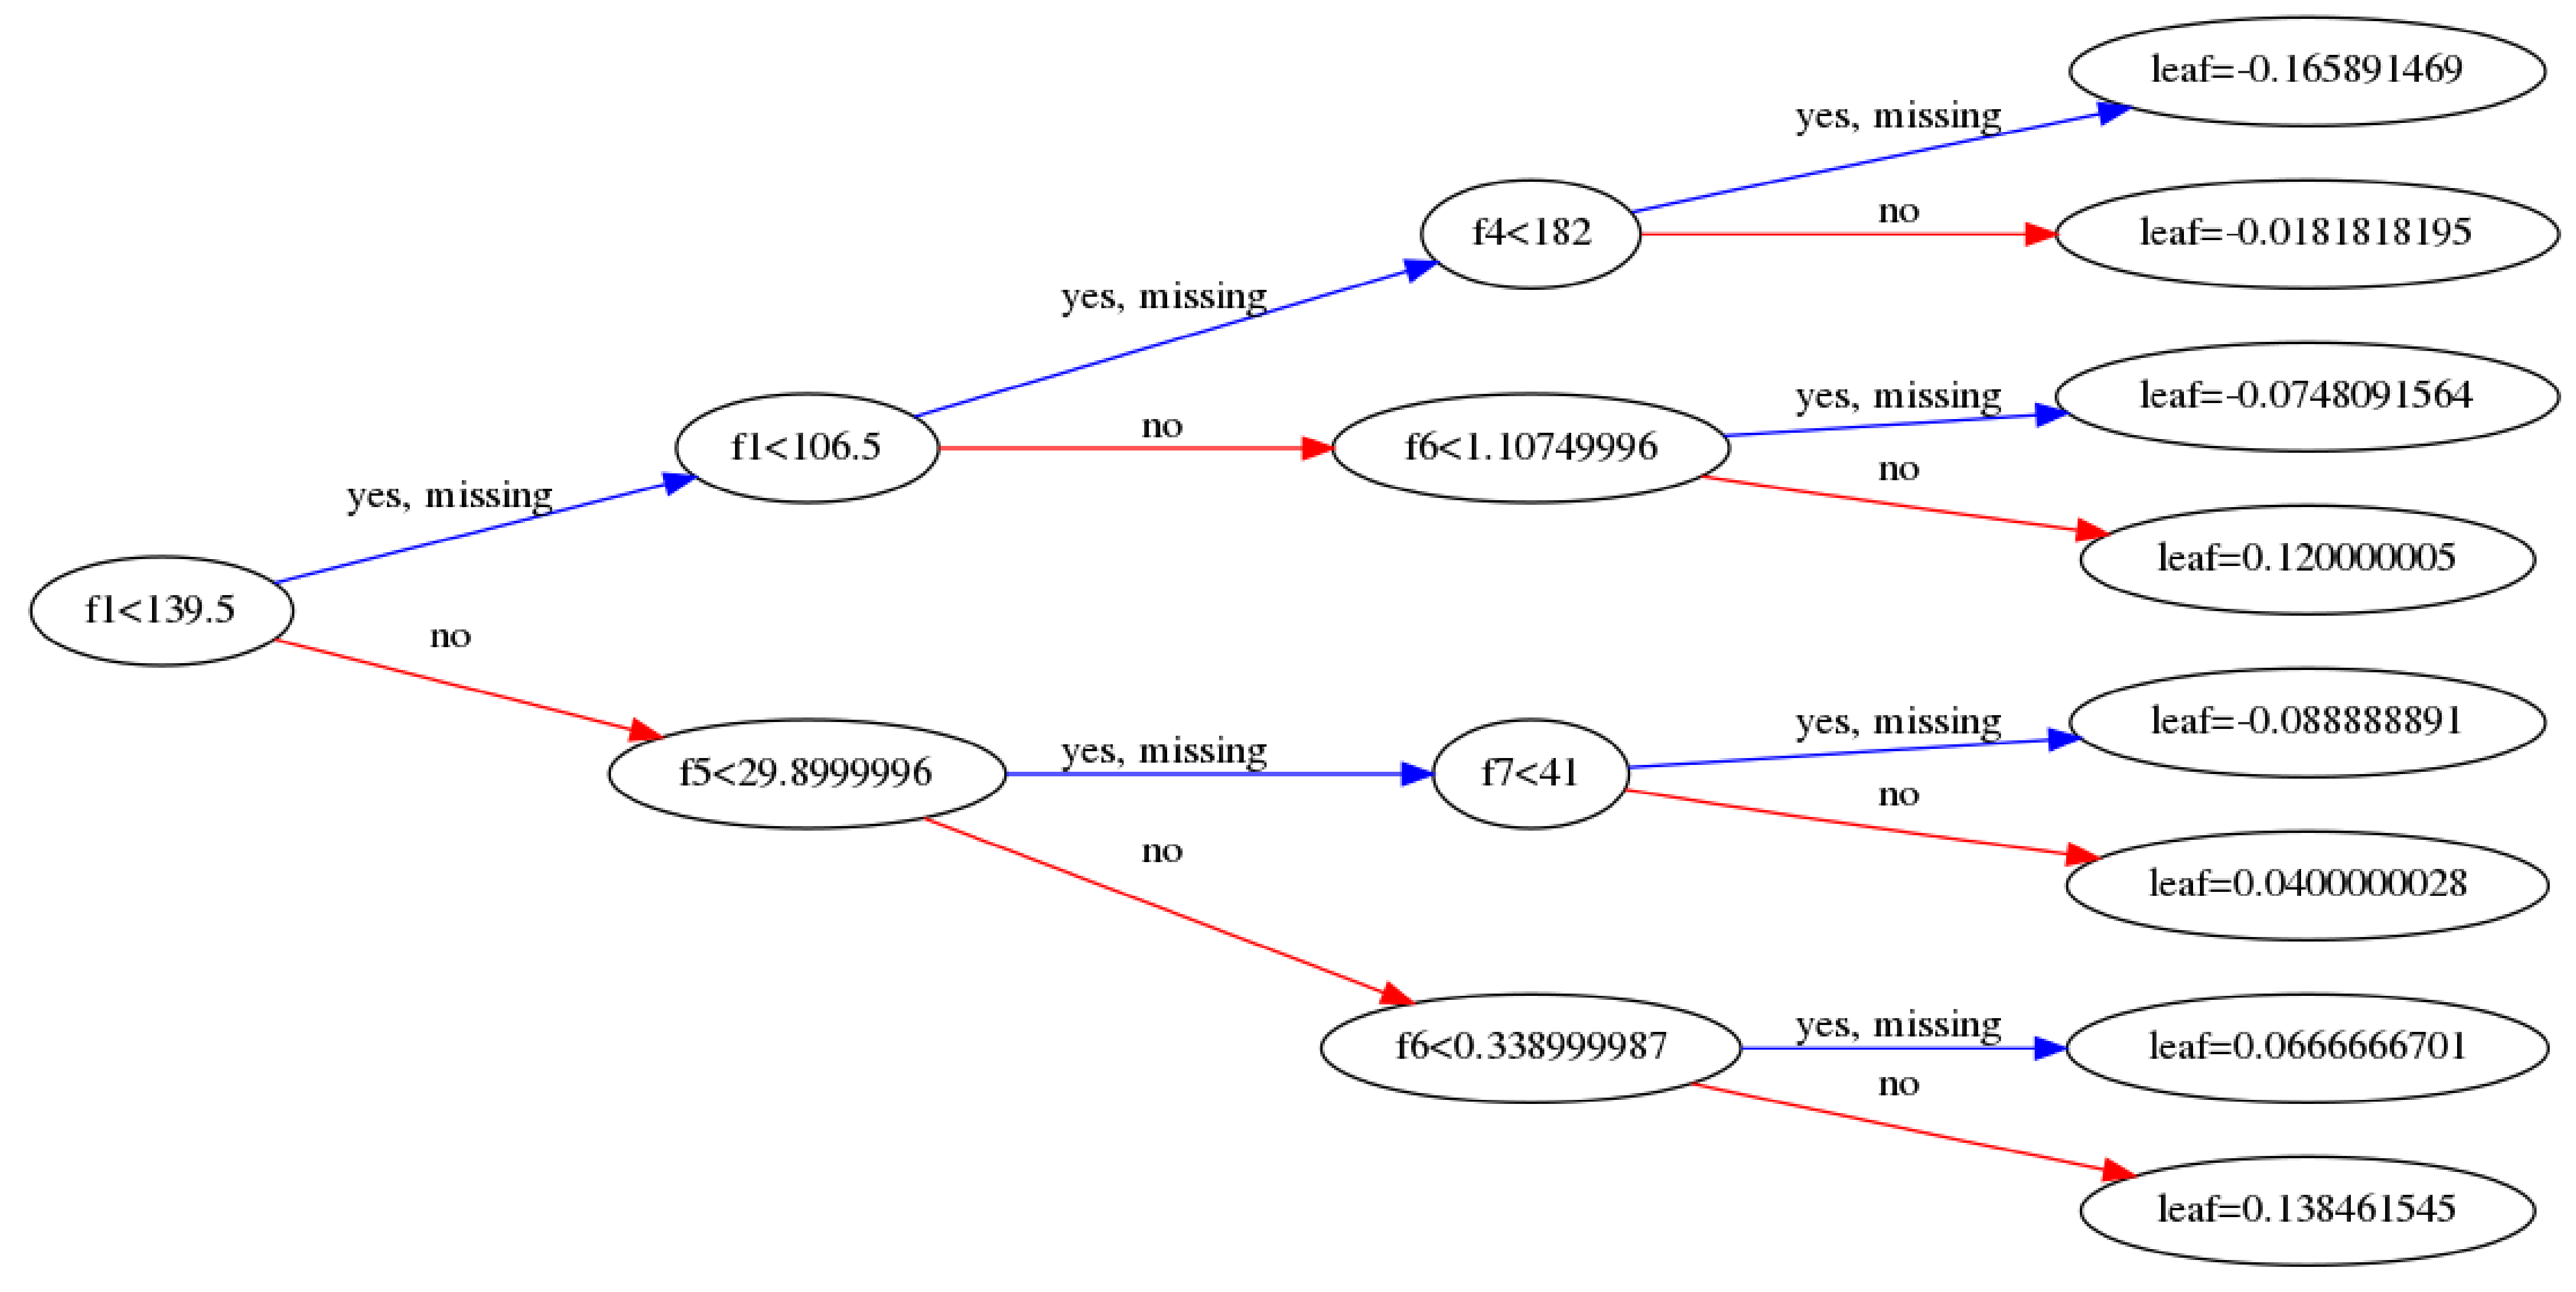

In [32]:
from xgboost import plot_tree
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

##set up the parameters
rcParams['figure.figsize'] = 80,50
plot_tree(model, num_trees=0,rankdir='LR')
plt.show()